# Fourier Transform

**Goal :**  Map out bimodal and unimodal signals

In [1]:
from datetime import date, timedelta
from math import *
import os

from dateutil.relativedelta import relativedelta
import ipywidgets as widgets
from ipywidgets import fixed
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from progressbar import ProgressBar
import rasterio as rio
from rasterio.windows import Window
import re
from scipy.fft import fft, ifft
import scipy.signal as ss
import seaborn as sns
import time
import xarray as xr

Functions

In [2]:
def extract_ts(rasters: list, lat: float, lon: float, N: int, raster_type: str, loc: str):
    '''Extracts time series from rasters list at location (lat, lon)
    loc = 'coordinate' or 'pixel' '''
    
    ts = []
    
    for rt in rasters:
        
        with rio.open(rt) as src:
            
            #selecting NxN pixel at lat lon coordinates
            
            if (loc == 'coordinate'):
                (y,x) = rio.transform.rowcol(src.transform, lat, lon)
            else:
                (x,y) = (lat,lon)
           
            subset = src.read(1, window=Window(x-(N/2),y-(N/2),N,N)) 
            
            #unscaling the values
            subset = unscaling(subset, raster_type)
            
            #mean over lat and lon
            m = np.mean(subset)
        
            #adding to ts
            ts.append(m)
    
    return ts


def unscaling(subset, raster_type: str):
    
    if (raster_type=="ndvi"):
        subset = subset/10000
    elif (raster_type=="tda" or raster_type=='tna'):
        subset =subset * 0.02 - 273.15
    else:
        pass

    return subset

In [3]:
def lta_dict(index: pd.DatetimeIndex, ts: pd.Series):
    
    lta_begin = date(2002,7,1)
    lta_end = date(2018,7,1)

    mondays = {'{}-{}'.format(x.month, x.day) for x in index}

    # initialize the dicts
    lta_dict = {}

    for md in mondays:

        lta = 0 
        nb = 0

        month, day = md.split('-')
        month, day = (int(month), int(day))

        # converting gregorian to DOY
        DOY = gregorian_to_DOY(month = month, day = day)

        for ix, date_sel in enumerate(index):

            # only select the dates in LTA period
            if date_sel < lta_begin or date_sel > lta_end:
                continue

            DOYsel = gregorian_to_DOY(month = date_sel.month, day = date_sel.day)

            if DOYsel == DOY:
                lta += ts[ix]
                nb += 1


        # add to LTA dict
        lta_dict[md] = lta/nb
        
    return lta_dict

def lta(index: pd.DatetimeIndex, ts: pd.Series):
    
    lta =  lta_dict(index, ts)    
    ts_lta = []


    for i,x in enumerate(index):

        key = '{}-{}'.format(x.month, x.day)
        ts_lta.append(lta[key])
        
    return ts_lta



In [4]:
def filename_to_gregorian(filename: str):
    '''Converts filename to gregorian date'''

    # seeking for date pattern in the filename
    dek = re.search(r'\d{4}\d{2}d\d{1}', filename).group()

    # getting year, month and dekad
    year = int(dek[0:4])
    month = int(dek[4:6])
    d = dek[6:8]

    if d=="d1":
        greg_date = date(year, month, 10)
    elif d=="d2":
        greg_date = date(year, month, 20)
    else:
        greg_date = date(year, month, 28)
        # We chose 28 because all months have at least 28 days

    return greg_date

def gregorian_to_DOY(month: int, day:int):
    '''Converts gregorian date to DOY'''
    
    # we chose 2020 randomly because the year isn't taken into account
    DOY = (date(2020,month,day) - date(2020, 1, 1)).days + 1
    return DOY

In [5]:
def raster_plot(raster):
    
    with rio.open(raster) as src:
        aoi = src.read(1) 
        im = plt.imshow(aoi);
        plt.colorbar()
        plt.clim(0,40)
        plt.title('rfe')

In [6]:
def select_point(raster, N):
    
    plt.figure(figsize=(20,7))
    
    im = plt.imshow(raster);
    im.set_clim(0,2)
    plt.title('Select pixel to analyse')
    latlon = plt.ginput(1) 
    print(round(latlon[0][0]), round(latlon[0][1]))
    return (round(latlon[0][0])*N,round(latlon[0][1])*N)       
    
def red_rectangle(raster1, raster2, x: int , y: int, N: int):
    
    fig, (ax1, ax2)  = plt.subplots(1,2,figsize=(20,10))
    
    with rio.open(raster2) as src:
        aoi = src.read(1)        
        aoi = unscaling(aoi, 'rfe')
        im = ax1.imshow(aoi);
        im.set_clim(0,40)
        fig.colorbar(im, ax = ax1)
        ax1.set_title('Selected Zone in Rainfall raster')
        ax1.set_xticks(np.linspace(0, 500, num=7))
        ax1.set_yticks(np.linspace(0, 400, num=7))
        ax1.set_xticklabels([str(round(x,2)) for x in np.linspace(src.bounds.left, src.bounds.right, num=7)])
        ax1.set_yticklabels([str(round(x,2)) for x in np.linspace(src.bounds.top, src.bounds.bottom, num=7)])

        rect = patches.Rectangle((x - N/2,y - N/2),N,N,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect)
     
    im = ax2.imshow(raster1)
    im.set_clim(0,2)
    fig.colorbar(im, ax = ax2)
    ax2.set_title('Selected Zone in Ratio map')
    rect = patches.Rectangle((x//5 - 0.5, y//5 - 0.5),1,1,linewidth=1,edgecolor='r',facecolor='none')
    ax2.add_patch(rect)

### Points analysis

Downloading data

In [7]:
rasters_rfe = ['RFE/'+ x for x in os.listdir('RFE')][-400:]

#creating date index
dates_all = pd.DatetimeIndex([filename_to_gregorian(x) for x in rasters_rfe])
dates_3cycles = dates_all[(dates_all>np.datetime64(date(2010,1,1)))*(dates_all<np.datetime64(date(2013,1,1)))]

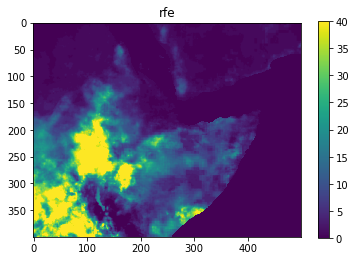

In [8]:
raster_plot(rasters_rfe[0])

In [9]:
ts1 = extract_ts(rasters_rfe, lat = 300, lon = 300, N = 5, raster_type= 'rfe', loc = 'pixel')
ts2 = extract_ts(rasters_rfe, lat = 100, lon = 150, N = 5, raster_type= 'rfe', loc = 'pixel')

ts1_lta = lta(dates_all, ts1)
ts2_lta = lta(dates_all, ts2)

#ts1_lta = lta(dates_3cycles, ts1)
#ts2_lta = lta(dates_3cycles, ts2)

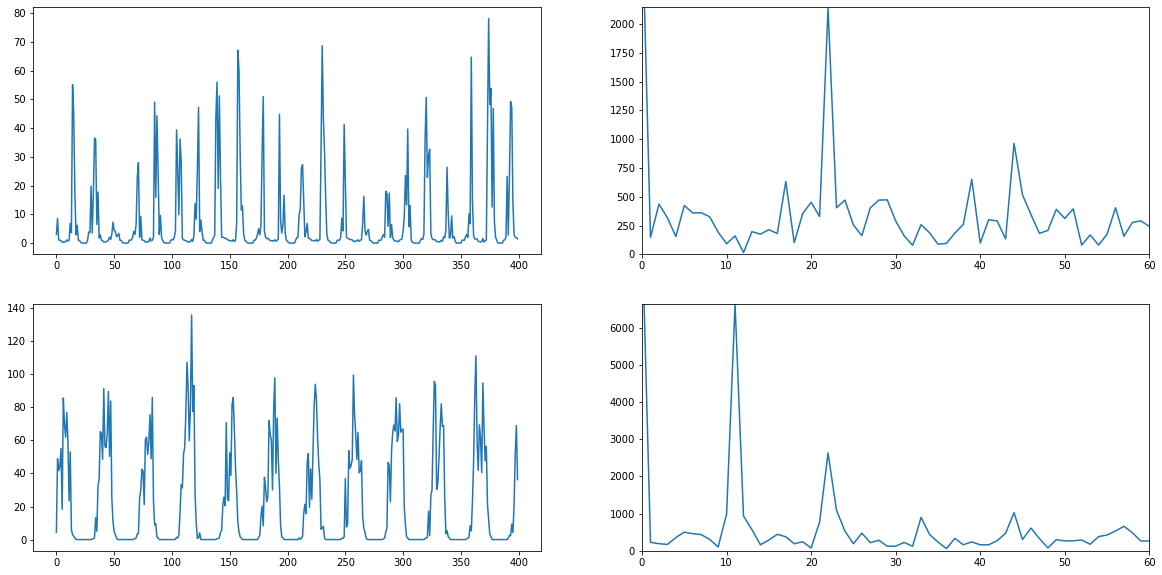

In [10]:
# Number of sample points
N = len(ts1)

yf1 = fft(ts1)
yf2 = fft(ts2)

fig, axs  = plt.subplots(2,2,figsize=(20,10))

freq1 = np.abs(yf1[0:N//2])
axs[0,0].plot(ts1)
axs[0,1].plot(freq1)
axs[0,1].set_xlim((0,60))
axs[0,1].set_ylim((0,max(freq1[1:])+10));

freq2 = np.abs(yf2[0:N//2])
axs[1,0].plot(ts2)
axs[1,1].plot(freq2)
axs[1,1].set_xlim((0,60))
axs[1,1].set_ylim((0,max(freq2[1:])+10));

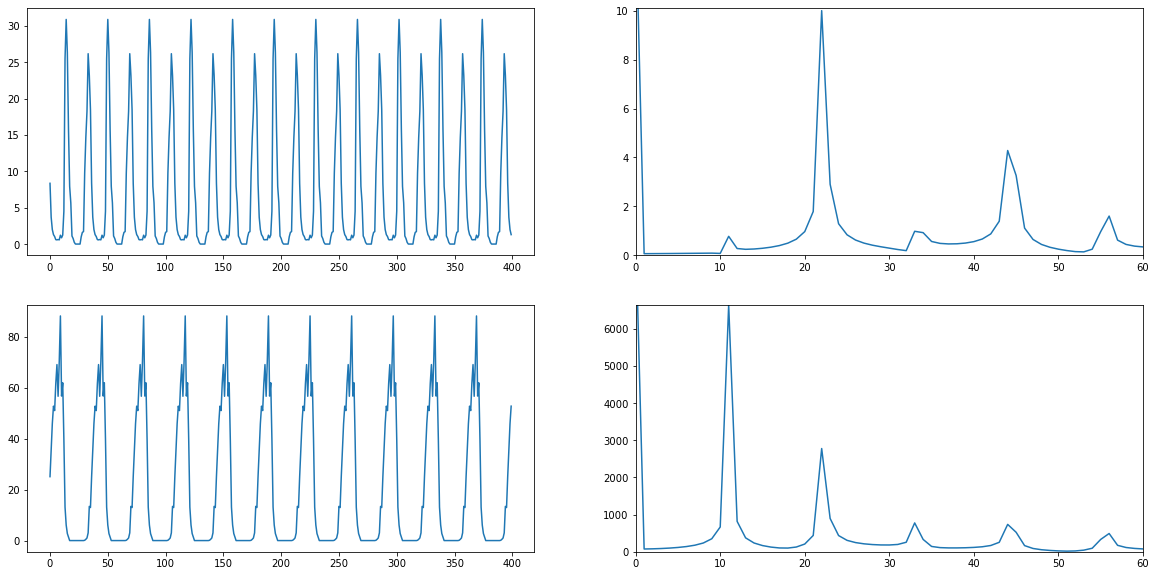

In [11]:
yf1 = fft(ts1_lta)
yf2 = fft(ts2_lta)

fig, axs  = plt.subplots(2,2,figsize=(20,10))


freq1 = 2.0/N * np.abs(yf1[0:N//2])
axs[0,0].plot(ts1_lta)
axs[0,1].plot(freq1)
axs[0,1].set_xlim((0,60))
axs[0,1].set_ylim((0,max(freq1[1:])+0.1));

freq2 = np.abs(yf2[0:N//2])
axs[1,0].plot(ts2_lta)
axs[1,1].plot(freq2)
axs[1,1].set_xlim((0,60))
axs[1,1].set_ylim((0,max(freq2[1:])+10));

Calculating the **ratio between 2 peaks**

In [12]:
a,b = ss.find_peaks(freq1, height=(0, inf))
x = b['peak_heights']
max1 = max(x)
id_max1 = a[np.where(x==max1)[0][0]]
x2 = np.delete(x, np.where(x==max1)[0][0])
max2 = max(x2)
id_max2 = a[np.where(x==max2)[0][0]]
ratio1 = max2/max1
print('Id max ts1: ', id_max1, id_max2)
print('Ratio ts1: ', round(ratio1,2))

a,b = ss.find_peaks(freq2, height=(0, inf))
x = b['peak_heights']
max1 = max(x)
id_max1 = a[np.where(x==max1)[0][0]]
x2 = np.delete(x, np.where(x==max1)[0][0])
max2 = max(x2)
id_max2 = a[np.where(x==max2)[0][0]]
ratio2 = max2/max1
print('Id max ts2: ', id_max1, id_max2)
print('Ratio ts2: ', round(ratio2,2))

Id max ts1:  22 44
Ratio ts1:  0.43
Id max ts2:  11 22
Ratio ts2:  0.42


We have 2 major peaks: one at 11 and one at 22. This is because we have:

$T = \frac{N}{11} = 36$ with $N = 400$ (time series length) 

The peak at 11 is higher for **unimodal** time series because the time period of the curve is 36 days.

The peak at 22 is higher for **bimodal** time series because the time period of the curve is 36/2 = 18 days.

### Mapping

In [13]:
rfe = ['RFE/'+ x for x in os.listdir('RFE')][-400:]
dates = pd.DatetimeIndex([filename_to_gregorian(x) for x in rfe])
rasters = []

#progressbar
pbar = ProgressBar()

for rt in pbar(rfe):   
    with rio.open(rt) as src:           
        rasters.append(src.read(1))

rfe_map = xr.DataArray(rasters,
                dims=('time','lat','lon'),
                coords={'time': dates})

100% |########################################################################|


In [14]:
start_time = time.time()

N = 5

ratio = np.zeros((ceil(len(rfe_map.lat.values)/N), ceil(len(rfe_map.lon.values)/N)))

pbar = ProgressBar()
for i in pbar(np.arange(0,len(rfe_map.lat.values),N)):
    for j in np.arange(0,len(rfe_map.lon.values),N):
        
        ts = rfe_map.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values
        ts_lta = lta(dates, ts)
        
        M = len(ts_lta)

        f = fft(ss.detrend(ts_lta))        
        freq = np.abs(f[0:M//2])
            
        if (np.all(np.diff(ts,axis=0)==0)):
            ratio[int(i/N),int(j/N)] = np.nan
        else:
            ratio[int(i/N),int(j/N)] = freq[11]/freq[22]
            
print("--- %s seconds ---" % (time.time() - start_time))

--- 306.6591432094574 seconds ---


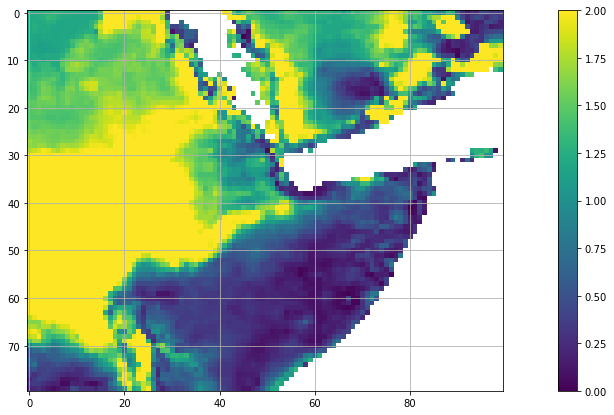

In [15]:
plt.figure(figsize=(20,7))
plt.imshow(ratio)
plt.colorbar()
plt.clim(0,2)
plt.grid()

**Checking odd pixels**

72.0 15.0


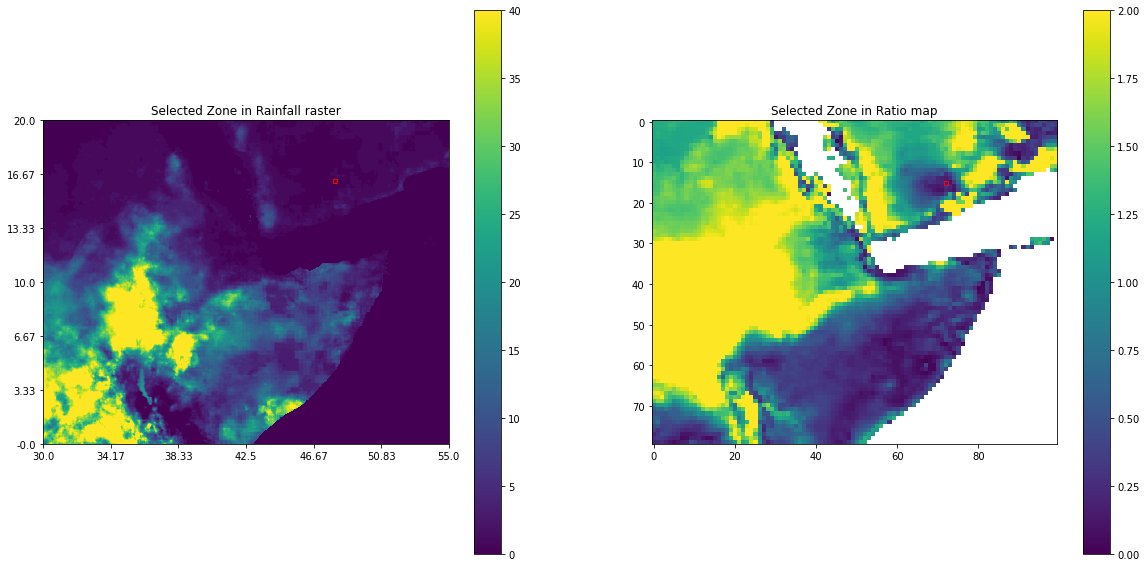

In [16]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

(x,y) = select_point(ratio, N)

matplotlib.use("Agg")

red_rectangle(ratio, rasters_rfe[0], x, y, N)

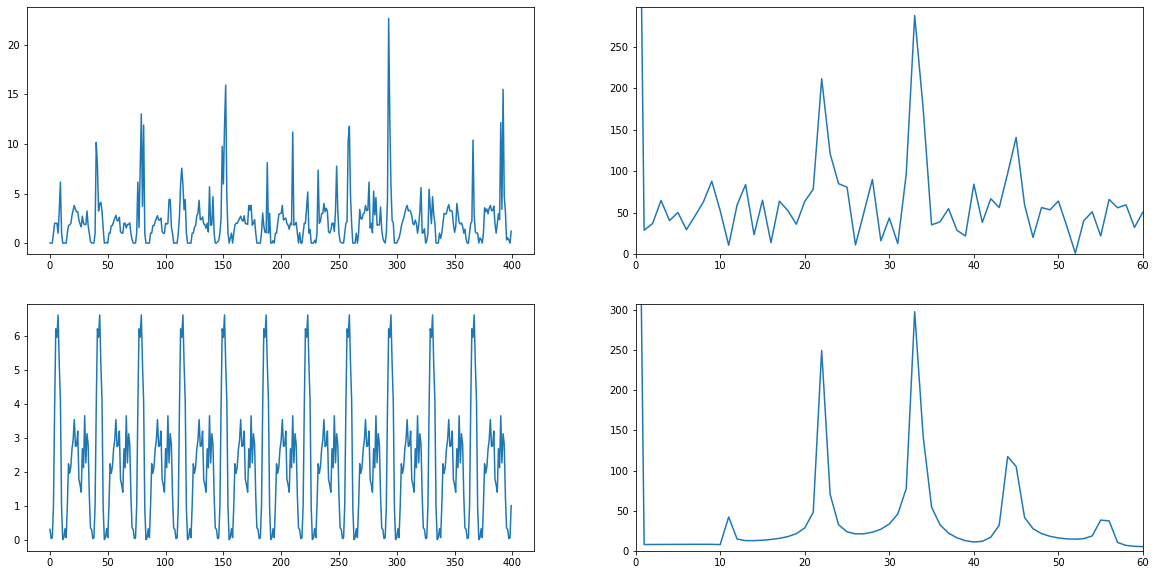

In [17]:
ts = extract_ts(rasters_rfe, lat = x, lon = y, N = N, raster_type= 'rfe', loc = 'pixel')
ts_lta = lta(dates_all, ts)
M = len(ts)

yf = fft(ts)

fig, axs  = plt.subplots(2,2,figsize=(20,10))

freq = np.abs(yf[0:M//2])
axs[0,0].plot(ts)
axs[0,1].plot(freq)
axs[0,1].set_xlim((0,60))
axs[0,1].set_ylim((0,max(freq[1:])+10));

yf = fft(ts_lta)

freq = np.abs(yf[0:M//2])
axs[1,0].plot(ts_lta)
axs[1,1].plot(freq)
axs[1,1].set_xlim((0,60))
axs[1,1].set_ylim((0,max(freq[1:])+10));

Notes:
- At (75,20) looks like we have trimodal ts

### CHANGE IN MODALITY OVER TIME

Comapring 200 first rasters and 200 last rasters. With:
- ratio<1 bimodal
- ratio>1 unimodal

In [18]:
start_time = time.time()

N = 5

ratio1 = np.zeros((ceil(len(rfe_map.lat.values)/N), ceil(len(rfe_map.lon.values)/N)))
ratio2 = np.zeros((ceil(len(rfe_map.lat.values)/N), ceil(len(rfe_map.lon.values)/N)))

pbar = ProgressBar()
for i in pbar(np.arange(0,len(rfe_map.lat.values),N)):
    for j in np.arange(0,len(rfe_map.lon.values),N):
        
        ts = rfe_map.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values
        
        ts1 = ts[0:200]
        ts2 = ts[200:400]
        dates1 = dates[0:200]
        dates2 = dates[0:200]
        
        ts1_lta = lta(dates1, ts1)
        ts2_lta = lta(dates2, ts2)
        
        M1 = len(ts1_lta)
        M2 = len(ts2_lta)

        f1 = fft(ss.detrend(ts1_lta))  
        f2 = fft(ss.detrend(ts2_lta))
        
        freq1 = np.abs(f1[0:M1//2])
        freq2 = np.abs(f2[0:M2//2])
            
        if (np.all(np.diff(ts1,axis=0)==0)):
            ratio1[int(i/N),int(j/N)] = np.nan
        else:
            ratio1[int(i/N),int(j/N)] = freq1[round(200/36)]/freq1[round(400/36)]
            
        if (np.all(np.diff(ts2,axis=0)==0)):
            ratio2[int(i/N),int(j/N)] = np.nan
        else:
            ratio2[int(i/N),int(j/N)] = freq2[round(200/36)]/freq2[round(400/36)]
            
print("--- %s seconds ---" % (time.time() - start_time))

--- 342.5685935020447 seconds ---


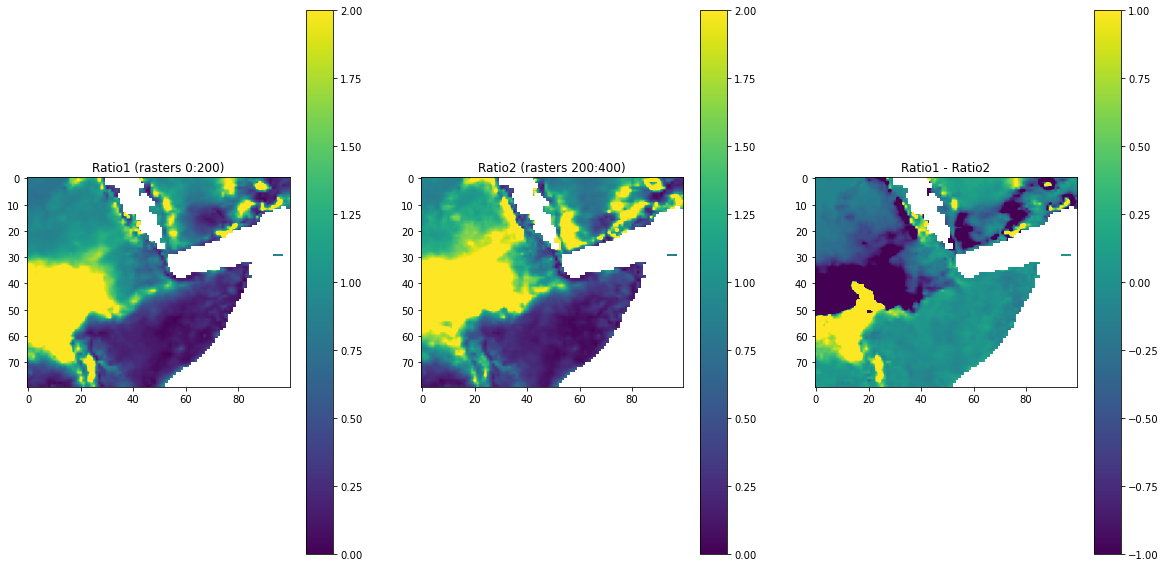

In [19]:
diff_ratio = ratio1 - ratio2

fig, axs  = plt.subplots(1,3,figsize=(20,10))

im0 = axs[0].imshow(ratio1);
fig.colorbar(im0, ax = axs[0])
im0.set_clim(0,2)
axs[0].set_title('Ratio1 (rasters 0:200)')

im1 = axs[1].imshow(ratio2);
fig.colorbar(im1, ax = axs[1])
im1.set_clim(0,2)
axs[1].set_title('Ratio2 (rasters 200:400)')

im2 = axs[2].imshow(diff_ratio);
fig.colorbar(im2, ax = axs[2])
im2.set_clim(-1,1)
axs[2].set_title('Ratio1 - Ratio2');

<ipython-input-20-f37227b59bbd>:4: RuntimeWarning: invalid value encountered in greater_equal
  ratio1_bin[ratio1_bin >= threshold] = 1
<ipython-input-20-f37227b59bbd>:5: RuntimeWarning: invalid value encountered in less
  ratio1_bin[ratio1_bin < threshold] = 0
<ipython-input-20-f37227b59bbd>:8: RuntimeWarning: invalid value encountered in greater_equal
  ratio2_bin[ratio2_bin >= threshold] = 1
<ipython-input-20-f37227b59bbd>:9: RuntimeWarning: invalid value encountered in less
  ratio2_bin[ratio2_bin < threshold] = 0


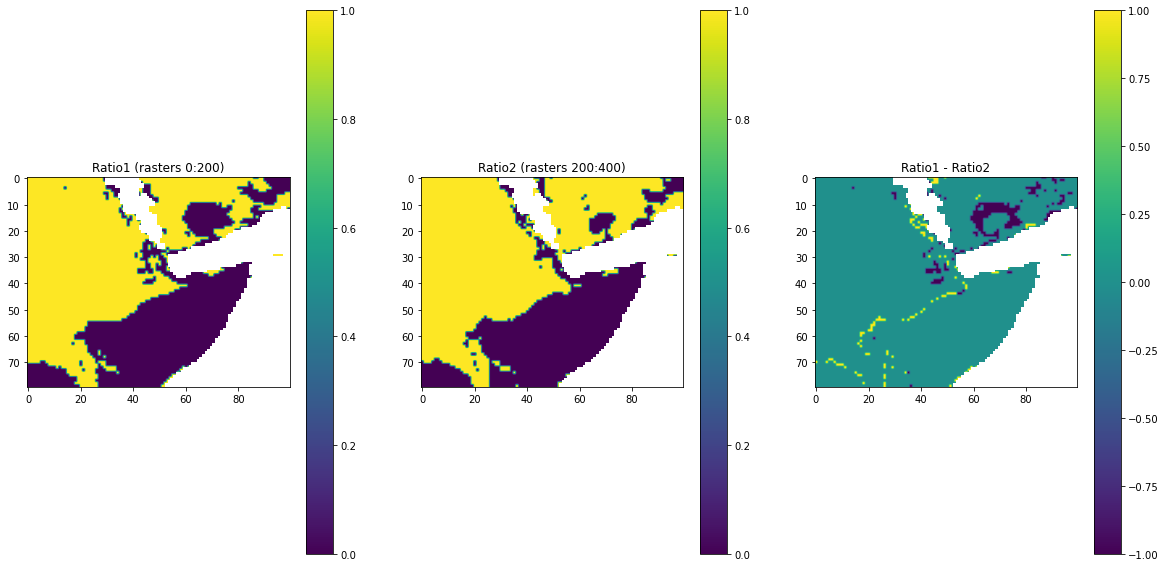

In [20]:
threshold = 0.7

ratio1_bin = np.copy(ratio1)
ratio1_bin[ratio1_bin >= threshold] = 1
ratio1_bin[ratio1_bin < threshold] = 0

ratio2_bin = np.copy(ratio2)
ratio2_bin[ratio2_bin >= threshold] = 1
ratio2_bin[ratio2_bin < threshold] = 0

diff_ratio_bin = ratio1_bin - ratio2_bin

fig, axs  = plt.subplots(1,3,figsize=(20,10))

im0 = axs[0].imshow(ratio1_bin);
fig.colorbar(im0, ax = axs[0])
axs[0].set_title('Ratio1 (rasters 0:200)')

im1 = axs[1].imshow(ratio2_bin);
fig.colorbar(im1, ax = axs[1])
axs[1].set_title('Ratio2 (rasters 200:400)')

im2 = axs[2].imshow(diff_ratio_bin);
fig.colorbar(im2, ax = axs[2])
axs[2].set_title('Ratio1 - Ratio2');